# Introduction 


## A client would like to open a business at Downtown Toronto but he is not sure what type of business or which Neighbourhood will make a good investment.


####  Used wikipedia Canada postal codes to identify number of neighbourhoods in Downtown Toronto.
#### Use foursquare data to identify which is venues are most frequency searched in Downtown Toronto.


In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [2]:
import pandas as pd
dfge = pd.read_csv("https://cocl.us/Geospatial_data")
dfge.rename(columns={'Postal Code': 'Postcode'}, inplace=True)
df = pd.read_html("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")[0]
indexNames = df[ df['Borough'] == "Not assigned" ].index
df.drop(indexNames , inplace=True)
df['Neighbourhood'].loc[df['Neighbourhood'] == "Not assigned"] = df['Borough']
df.sort_values(by=['Postcode'])
#df = df.groupby(['Postcode','Borough'])['Neighbourhood'].apply(', '.join).reset_index()
df = pd.merge(df[['Postcode','Borough','Neighbourhood']],
                 dfge[['Postcode','Latitude', 'Longitude']],
                 on='Postcode', 
                 how='left')
df.rename(columns={'Neighbourhood': 'Neighborhood'}, inplace=True)
df.drop(columns=['Postcode'], axis=1, inplace=True)

neighborhoods_subset = df[df['Borough'] == 'Downtown Toronto'].reset_index(drop=True)
neighborhoods_subset.head()


,Borough,Neighborhood,Latitude,Longitude
0,Downtown Toronto,Harbourfront,43.654260,-79.360636
1,Downtown Toronto,Regent Park,43.654260,-79.360636
2,Downtown Toronto,Ryerson,43.657162,-79.378937
3,Downtown Toronto,Garden District,43.657162,-79.378937
4,Downtown Toronto,St. James Town,43.651494,-79.375418


In [3]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20190526' # Foursquare API version

In [4]:
neighborhood_name = neighborhoods_subset.loc[0, 'Neighborhood']
neighborhood_latitude = neighborhoods_subset.loc[0, 'Latitude'] 
neighborhood_longitude = neighborhoods_subset.loc[0, 'Longitude']

LIMIT = 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
results = requests.get(url).json()


In [5]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [6]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

#nearby_venues



In [7]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)
print (nearby_venues)

                                               name             categories  \
0                                  Roselle Desserts                 Bakery   
1                                     Tandem Coffee            Coffee Shop   
2   Toronto Cooper Koo Family Cherry St YMCA Centre   Gym / Fitness Center   
3                               Body Blitz Spa East                    Spa   
4                                Morning Glory Cafe         Breakfast Spot   
5                                    Impact Kitchen             Restaurant   
6                            Figs Breakfast & Lunch         Breakfast Spot   
7                                   Corktown Common                   Park   
8                          Dominion Pub and Kitchen                    Pub   
9                  The Distillery Historic District          Historic Site   
10                              SOMA chocolatemaker         Chocolate Shop   
11                         Distillery Sunday Market         Farm

In [8]:
neighborhoods_subset_venues = getNearbyVenues(names=neighborhoods_subset['Neighborhood'],
                                   latitudes=neighborhoods_subset['Latitude'],
                                   longitudes=neighborhoods_subset['Longitude']
                                  )
#print(neighborhoods_subset_venues.shape)
#neighborhoods_subset_venues.head()
neighborhoods_subset_venues.groupby('Neighborhood').count()
#print('There are {} uniques categories.'.format(len(neighborhoods_subset_venues['Venue Category'].unique())))

Harbourfront
Regent Park
Ryerson
Garden District
St. James Town
Berczy Park
Central Bay Street
Christie
Adelaide
King
Richmond
Harbourfront East
Toronto Islands
Union Station
Design Exchange
Toronto Dominion Centre
Commerce Court
Victoria Hotel
Harbord
University of Toronto
Chinatown
Grange Park
Kensington Market
CN Tower
Bathurst Quay
Island airport
Harbourfront West
King and Spadina
Railway Lands
South Niagara
Rosedale
Stn A PO Boxes 25 The Esplanade
Cabbagetown
St. James Town
First Canadian Place
Underground city
Church and Wellesley


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Adelaide,100,100,100,100,100,100
Bathurst Quay,15,15,15,15,15,15
Berczy Park,56,56,56,56,56,56
CN Tower,15,15,15,15,15,15
Cabbagetown,46,46,46,46,46,46
Central Bay Street,87,87,87,87,87,87
Chinatown,100,100,100,100,100,100
Christie,16,16,16,16,16,16
Church and Wellesley,86,86,86,86,86,86


In [9]:
# one hot encoding
subset_onehot = pd.get_dummies(neighborhoods_subset_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
subset_onehot['Neighborhood'] = neighborhoods_subset_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [subset_onehot.columns[-1]] + list(subset_onehot.columns[:-1])
subset_onehot = subset_onehot[fixed_columns]
subset_grouped = subset_onehot.groupby('Neighborhood').mean().reset_index()

subset_grouped.head()




    



,Neighborhood,Yoga Studio,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Butcher,Café,Camera Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store
0,Adelaide,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.040000,0.0,0.0,0.010000,0.01,0.0,0.02,0.0,0.0,0.0,0.000000,0.030000,0.000000,0.04,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.01,0.000000,0.01,0.020000,0.0,0.0,0.03,0.01,0.000000,0.050000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.010000,0.010000,0.060000,0.0,0.0,0.0,0.01,0.000000,0.0,0.020000,0.000000,0.03,0.000000,0.01,0.01,0.010000,0.01,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.01,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.01,0.0,0.000000,0.000000,0.0,0.0,0.0,0.020000,0.0,0.000000,0.01,0.0,0.000000,0.01,0.000000,0.010000,0.0,0.02,0.01,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030000,0.0,0.0,0.01,0.010000,0.000000,0.010000,0.020000,0.010000,0.000000,0.01,0.0,0.0,0.01,0.0,0.000000,0.010000,0.000000,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.000000,0.0,0.01,0.000000,0.01,0.0,0.01,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.020000,0.000000,0.000000,0.01,0.0,0.0,0.0,0.000000,0.0,0.01,0.020000,0.0,0.02,0.01,0.00000

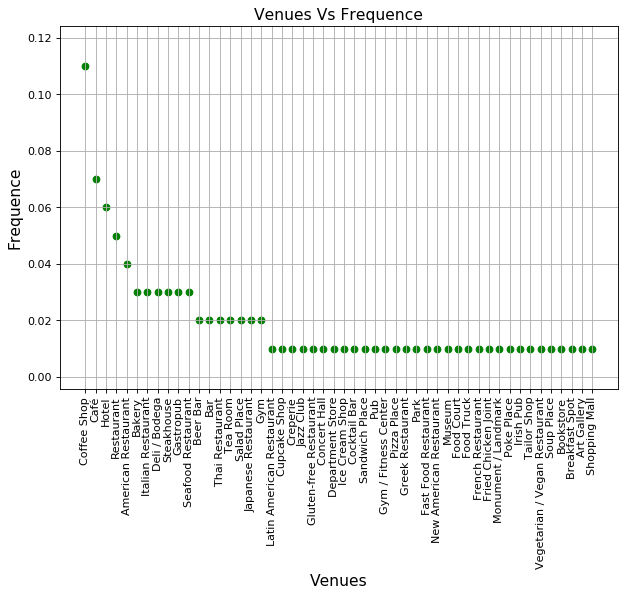

In [14]:
num_top_venues = 50

for hood in subset_grouped['Neighborhood']:
    #print("----"+hood+"----")
    temp = subset_grouped[subset_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    freq = temp.groupby('freq').sum()
    venue = temp.groupby('venue').sum()

    
    #neighborhoods_subset_venues.groupby('Neighborhood').count()
df=temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues)
df.columns=['VENUE','FREQ']
df.head()
%matplotlib inline 
import matplotlib.pyplot as plt 

plt.figure(figsize=(9,6), dpi=80)
plt.scatter(df['VENUE'], df['FREQ'], color='green')
plt.title('Venues Vs Frequence', fontsize=14)
plt.xlabel('Venues', fontsize=14)
plt.xticks(df['VENUE'], rotation='vertical')
plt.ylabel('Frequence', fontsize=14)
plt.grid(True)
plt.show()


In [11]:
# add neighborhood column back to dataframe
df['Neighborhood'] = neighborhoods_subset_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [subset_onehot.columns[-1]] + list(subset_onehot.columns[:-1])
subset_onehot = subset_onehot[fixed_columns]
subset_grouped = subset_onehot.groupby('Neighborhood').mean().reset_index()
subset_grouped.head()
df1 = subset_grouped[['Neighborhood','Coffee Shop','Café']]
df1.columns=['Neighborhood','Coffee Shop','Café']
df1 = df1.iloc[1:]
df1 = df1.round({'Café': 2})
df1 = df1.round({'Coffee Shop': 2})
indexNames = df1[ (df1['Café'] == 0.00) & (df1['Coffee Shop'] == 0.00) ].index
df1.drop(indexNames , inplace=True)
df1.head()


,Neighborhood,Coffee Shop,Café
2,Berczy Park,0.07,0.04
4,Cabbagetown,0.09,0.04
5,Central Bay Street,0.16,0.06
6,Chinatown,0.04,0.08
7,Christie,0.06,0.19


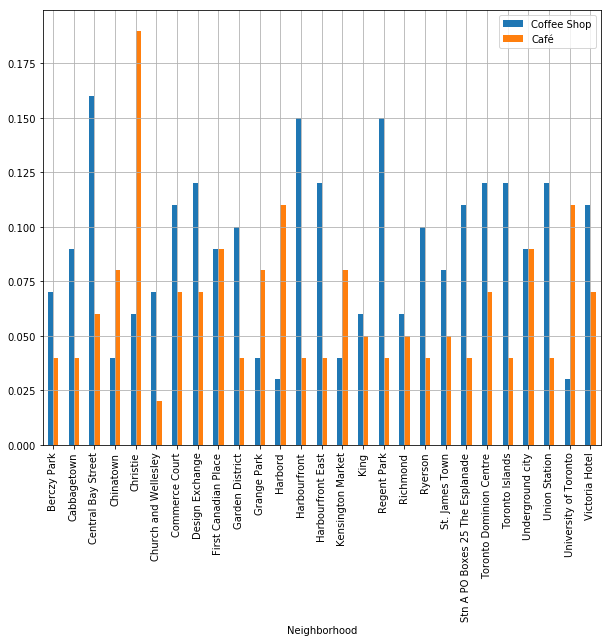

In [17]:
%matplotlib inline 
import matplotlib.pyplot as plot 

df1.plot(x='Neighborhood', y=['Coffee Shop','Café'], kind='bar',subplots=False, figsize=(10,8), grid=True)


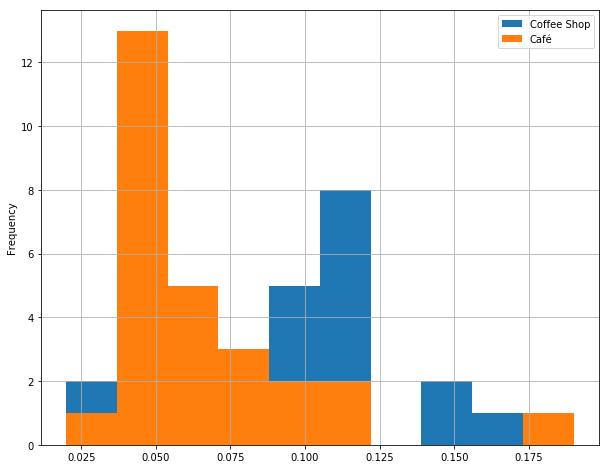

In [19]:
%matplotlib inline 
import matplotlib.pyplot as plot 

df1.plot(x='Neighborhood', y=['Coffee Shop','Café'], kind='hist',subplots=False, figsize=(10,8), grid=True)

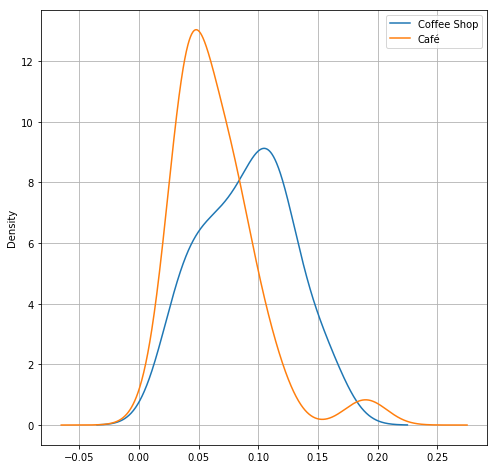

In [21]:
%matplotlib inline 
import matplotlib.pyplot as plot 

df1.plot(x='Neighborhood', y=['Coffee Shop','Café'], kind='kde',subplots=False, figsize=(8,8), grid=True)

#Kernel Density Estimation plot

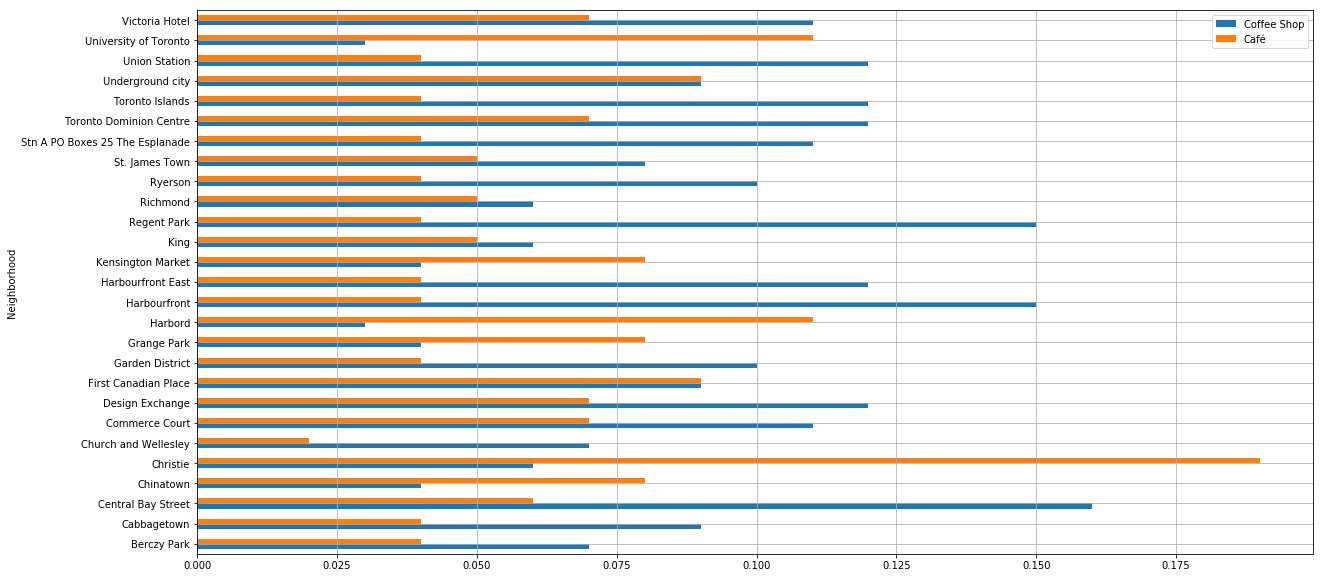

In [163]:
%matplotlib inline 
import matplotlib.pyplot as plot 

df1.plot(x='Neighborhood', y=['Coffee Shop','Café'], kind='barh',subplots=False, figsize=(20,10), grid=True)